### Serving Pre-Trained Model
<sub> Training model on sagemaker requires an instance with GPU, which is not included under the free tier. Deploying locally custom trained object detection Detectron2 model. Model is trained to detect olympic weightlifting plates. Using an image of Detectron2 on Sagemaker for simplicity.<sub>

### Steps:
1. Run push_model_image_to_aws.sh. This will push the model to S3 and the image to ECR.
2. 

#### To do:
    - Test on frame from lifting video
    - Set up Github Action CI/CD
        - Follow allan's repository for setting up directory for this
    - Set up Lambda Function

#### At this point image should be on AWS ECR, model has been zipped and uploaded to S3

In [28]:
# Gucciwang code
from sagemaker.pytorch import PyTorchModel
import sagemaker

bucket = 'detectron2-weightlifting'
sm_session = sagemaker.Session(default_bucket=bucket)
role = "arn:aws:iam::187135372127:role/SageMakerFullAccess"
region = 'us-east-2'
account = sm_session.account_id()

model_url = "s3://{}/{}".format(bucket, "model.tar.gz")
serve_container_name = 'sagemaker-d2-serve-weightlifting'
serve_container_version = 'latest'
serve_image_uri = f"{account}.dkr.ecr.{region}.amazonaws.com/{serve_container_name}:{serve_container_version}"
# inference_output = f"s3://{bucket}/{prefix_predictions}/{serve_container_name}/{Path(test_channel).name}_channel/{training_job_artifact.split('/')[-3]}"

remote_model=PyTorchModel(name='d2-deploy',
                         model_data=model_url,
                         role=role,
                         sagemaker_session=sm_session,
                         entry_point="inference.py",# typically train.py, but since we are bringing pre-trained model, just need inference
                         image_uri=serve_image_uri,
                         framework_version="1.6.0",
                         py_version='py3')

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\timot\AppData\Local\sagemaker\sagemaker\config.yaml


In [50]:
import time
# deploy model to an endpoint
# Using real-time because serverless can't support the image size. 
endpoint_name = 'd2-serve' #+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
remote_predictor = remote_model.deploy(
                         instance_type='ml.g4dn.xlarge', # has GPU - EC2 instance type to deploy model to
                        #  instance_type = 'ml.m5.xlarge', # no GPU
                         initial_instance_count=1, # number of instances to run in endpoint
                         endpoint_name=endpoint_name, # define a unique endpoint name; if ommited, Sagemaker will generate it based on used container
                         wait=True, # wait for deployment of model completes to call             
                         )

Using already existing model: d2-deploy


-------!

In [ ]:
# serverless deploy, no gPU available though. limit on image size as well. 
# from sagemaker.serverless import ServerlessInferenceConfig
# import time
# endpoint_name1 = endpoint_name + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
# serverless_predictor = remote_model.deploy(
#     serverless_inference_config = ServerlessInferenceConfig(
#         memory_size_in_mb=3072,
#         max_concurrency=5,
#     ),
#     endpoint_name=endpoint_name1
# )

In [1]:
import torch
from detectron2.structures import Instances, Boxes
import json 

def json_to_d2(pred_dict, device):
    """ 
    Client side helper function to deserialize the JSON msg back to d2 outputs 
    """
    
    pred_dict = json.loads(pred_dict)
    for k, v in pred_dict.items():
        if k=="pred_boxes":
            boxes_to_tensor = torch.FloatTensor(v).to(device)
            pred_dict[k] = Boxes(boxes_to_tensor)
        if k=="scores":
            pred_dict[k] = torch.Tensor(v).to(device)
        if k=="pred_classes":
            pred_dict[k] = torch.Tensor(v).to(device).to(torch.uint8)
    
    height, width = pred_dict['image_size']
    del pred_dict['image_size']

    inst = Instances((height, width,), **pred_dict)
    
    return {'instances':inst}

In [18]:
import cv2
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader

barbell_train_metadata = MetadataCatalog.get("barbell_train")

videoPath = 'test_video_lidayin.mp4'
video = cv2.VideoCapture(videoPath)
frame_num = 512
video.set(cv2.CAP_PROP_POS_FRAMES, frame_num) 
ret, frame = video.read()
# visualizer = Visualizer(frame[:, :, ::-1], metadata=barbell_train_metadata, scale=0.5)
# cv2.imwrite(f'test/{frame_num}.jpg', frame)
cv2.imshow('barbell',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
import io
from PIL import Image

image_pil = Image.fromarray(frame)
image_bytes_io = io.BytesIO()
image_pil.save(image_bytes_io, format="JPEG")
image_bytes_io.seek(0)
type(image_bytes_io)

_io.BytesIO

In [5]:
import boto3
endpoint_name = 'd2-serve'

sagemaker_client = boto3.client('sagemaker-runtime')
response = sagemaker_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=image_bytes_io,
    ContentType='image/jpeg',
    Accept="json"
)
response_dict = response['Body'].read()
response_dict

b'{"pred_boxes": [[389.62933349609375, 266.15618896484375, 476.5494689941406, 357.84625244140625], [240.6284942626953, 270.5348815917969, 321.9312438964844, 351.352294921875], [112.91461181640625, 286.7315368652344, 163.68504333496094, 346.3855895996094], [158.0849609375, 288.5142517089844, 199.3854217529297, 344.60382080078125]], "scores": [0.994702160358429, 0.9903990626335144, 0.9880098700523376, 0.9779611229896545], "pred_classes": [1, 1, 1, 1], "image_size": [360, 640]}'

In [85]:
response_dict

b'{"pred_boxes": [[389.62933349609375, 266.15618896484375, 476.5494689941406, 357.84625244140625], [240.6284942626953, 270.5348815917969, 321.9312438964844, 351.352294921875], [112.91461181640625, 286.7315368652344, 163.68504333496094, 346.3855895996094], [158.0849609375, 288.5142517089844, 199.3854217529297, 344.60382080078125]], "scores": [0.994702160358429, 0.9903990626335144, 0.9880098700523376, 0.9779611229896545], "pred_classes": [1, 1, 1, 1], "image_size": [360, 640]}'

In [6]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data.catalog import MetadataCatalog, DatasetCatalog
import os
import json

# Use this if you have the dataset locally referencable 
# dataset_name = "test"
# dataset_location = "/data/"
# annotation_file = "test.json"
# image_dir = "test"

# Use this if you want to just create an empty dataset that has the classmap 
dataset_name = "test"
dataset_location = "Barbell-small-2\test"
annotation_file = "_annotations.coco.json"
image_dir = "Barbell-small-2\test"

if not 'test' in DatasetCatalog.list():
    register_coco_instances(dataset_name, {}, os.path.join(dataset_location, annotation_file), 
                            os.path.join(dataset_location, image_dir))
cb_meta = MetadataCatalog.get(dataset_name); #del cb_meta.thing_classes

# This section should be run just to be explicit to Detectron which classes are which! 
MetadataCatalog.get('test').thing_classes = ['Lifter', 'Olympic Plate'] # put more here! 
# MetadataCatalog.get('test').thing_dataset_id_to_contiguous_id={1: 0} # Update the mapping here as so too for class 0 to be background!

DETECTED: Weightlifting Plate, confidence: 0.994702160358429, box: 389 266 476 357

DETECTED: Weightlifting Plate, confidence: 0.9903990626335144, box: 240 270 321 351

DETECTED: Weightlifting Plate, confidence: 0.9880098700523376, box: 112 286 163 346

DETECTED: Weightlifting Plate, confidence: 0.9779611229896545, box: 158 288 199 344



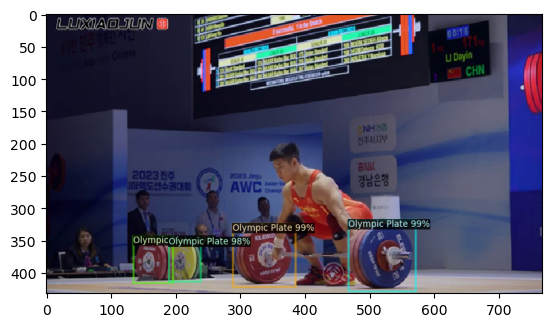

In [23]:
import cv2
from detectron2.utils.visualizer import ColorMode, Visualizer
import matplotlib.pyplot as plt
img_name = 'test'
classID_name = {1: 'Weightlifting Plate'}
device = 'cpu'
predictions = json_to_d2(response_dict, device)
metadata = MetadataCatalog.get('test')
# Extract predictions
preds = predictions["instances"].to("cpu")
boxes = preds.pred_boxes.tensor.numpy()
scores = preds.scores.tolist()
classes = preds.pred_classes.tolist()

for i in range(len(boxes)):
    left, top, right, bot = boxes[i]
    print(f"DETECTED: {classID_name[classes[i]]}, confidence: {scores[i]}, box: {int(left)} {int(top)} {int(right)} {int(bot)}\n")
# visualize
# im = cv2.imread(img_name)
v = Visualizer(frame[:, :, ::-1], # Visualizer reads image numpy array
                metadata=cb_meta,
                scale=1.2)
out = v.draw_instance_predictions(preds)
image_final = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
plt.imshow(image_final)
plt.show()

In [9]:
from io import BytesIO
# from container_serving.d2_deserializer import json_to_d2
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
import matplotlib.pyplot as plt
import time 
%matplotlib inline

# use sagemaker package for less errors potentially
client = boto3.client('sagemaker-runtime')

accept_type = "json"
content_type = 'image/jpeg'
headers = {'content-type': content_type}
device = "cpu"
test_pics_dir = dataset_location

classID_name = {0: 'Weightlifting Plate'}

for img_ in os.listdir(test_pics_dir):
    
    img_name = test_pics_dir + img_
    print(img_name)
    
    payload = open(img_name, 'rb')
    device = "cpu"
    
    response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType=content_type,
    Accept = accept_type)
    
    if accept_type=="json":
        predictions = json_to_d2(response['Body'].read(), device)
    elif accept_type == "detectron2":
        print(response['Body'].read())
        stream = BytesIO(response['Body'].read())
        predictions = pickle.loads(stream.read())
        
    # Extract predictions
    preds = predictions["instances"].to("cpu")
    boxes = preds.pred_boxes.tensor.numpy()
    scores = preds.scores.tolist()
    classes = preds.pred_classes.tolist()
    
    for i in range(len(boxes)):
        left, top, right, bot = boxes[i]
        print(f"DETECTED: {classID_name[classes[i]]}, confidence: {scores[i]}, box: {int(left)} {int(top)} {int(right)} {int(bot)}\n")
    # visualize
    im = cv2.imread(img_name)
    v = Visualizer(im[:, :, ::-1],
                  metadata=cb_meta,
                  scale=1)
    out = v.draw_instance_predictions(predictions["instances"].to("cpu"))
    image_final = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    plt.imshow(image_final)
    plt.show()

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 's3://detectron2-weightlifting/test'

In [36]:
remote_predictor.delete_endpoint()